In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes
!pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.6 MB/s eta 0:00:00


In [2]:
#Initializing the environment
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [3]:
from graphframes import *
from pyspark import *
from pyspark.sql import *
import seaborn as sns
from pyspark.sql.functions import sum, count
import matplotlib.pyplot as plt
from graphframes import GraphFrame
import pyspark.sql.functions as F
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('SupplyChain Analysis').getOrCreate()

In [4]:
data_path = "DataCoSupplyChainDataset.csv"
supply_chain_df = spark.read.csv(data_path, header=True, inferSchema=True)

Top Selling Categories

The visualization below shows the top-selling categories based on total sales.From the graph, it's evident that Fishing, Cleats, and Camping & Hiking are the top three categories with the highest sales.This insight can be valuable for decision-making processes such as inventory management, marketing strategies, and product development.


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


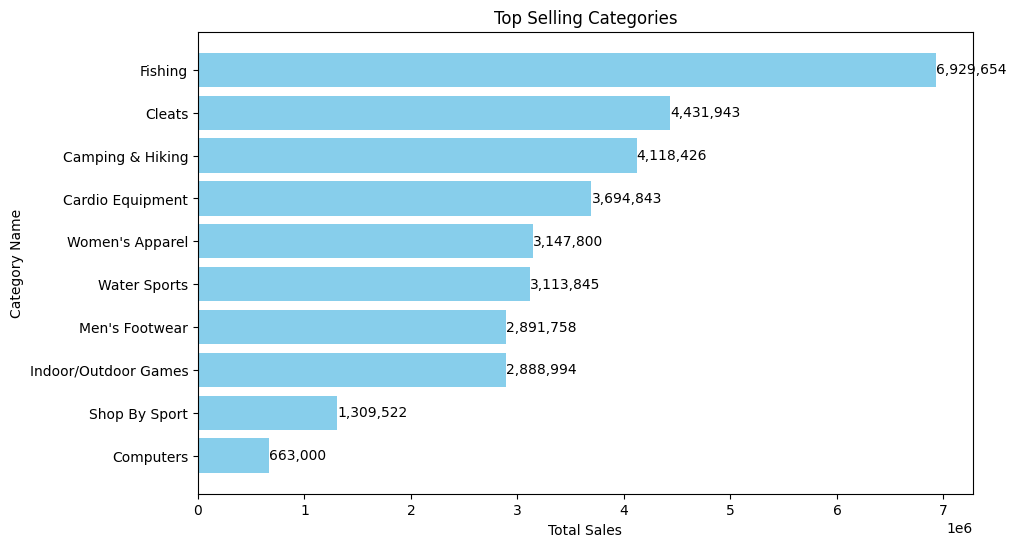

In [5]:
selected_columns = ['Category Name', 'Sales']
supply_chain_df_1 = supply_chain_df.select(selected_columns)

vertices_top = supply_chain_df_1.selectExpr("`Category Name` as id").distinct()
edges_top = supply_chain_df_1.withColumnRenamed("Category Name", "src").withColumnRenamed("Sales", "dst").select("src", "dst", "src", "dst")
g = GraphFrame(vertices_top, edges_top)
category_sales = g.edges.groupBy("src").sum("dst").orderBy("sum(dst)", ascending=False).limit(10)
category_sales_data = category_sales.collect()
categories = [row['src'] for row in category_sales_data]
sales = [row['sum(dst)'] for row in category_sales_data]
plt.figure(figsize=(10, 6))
bars = plt.barh(categories, sales, color='skyblue')
plt.xlabel('Total Sales')
plt.ylabel('Category Name')
plt.title('Top Selling Categories')
for bar, sale in zip(bars, sales):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{sale:,.0f}', va='center', ha='left')
plt.gca().invert_yaxis()
plt.show()

**Average Shipping Times by different Shipping Modes**

The analysis of average shipping time by shipping mode reveals distinct performance trends across different modes within the supply chain. The 'same day' mode exhibits the shortest average shipping time, indicating efficient delivery, while 'Second and Standard class' show the longest average shipping time, suggesting potential areas for improvement in delivery timelines. Optimizing logistics strategies for each mode could enhance overall performance and customer satisfaction by addressing delays and ensuring timely deliveries, thus optimizing the supply chain operations for improved efficiency and customer experience.

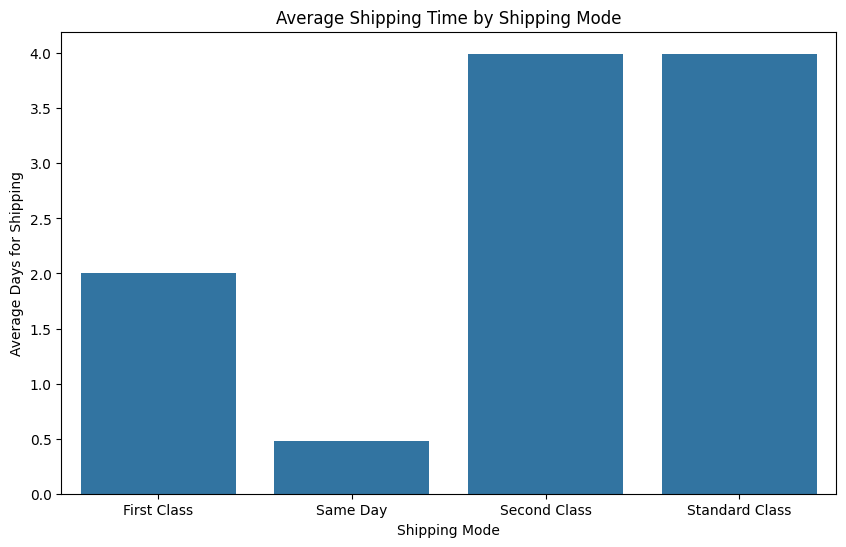

In [6]:
vertices = supply_chain_df.selectExpr("`Shipping Mode` as id").distinct()
edges = supply_chain_df.selectExpr("`Shipping Mode` as src", "`Delivery Status` as dst", "`Days for shipping (real)` as days")
g = GraphFrame(vertices, edges)
avg_shipping_time_per_mode = g.edges.groupBy("src").agg(F.avg("days").alias("avg_days"))
avg_shipping_time_df = avg_shipping_time_per_mode.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="src", y="avg_days", data=avg_shipping_time_df)
plt.title("Average Shipping Time by Shipping Mode")
plt.xlabel("Shipping Mode")
plt.ylabel("Average Days for Shipping")
plt.show()


**Percentage of Late Deliveries by Shipping Mode**


The examination of the percentage of late deliveries by shipping mode unveils insights into the timeliness of order fulfillment across various modes within the supply chain. It provides a clear indication of the effectiveness of each mode in meeting delivery deadlines and highlights potential areas for improvement. By identifying the shipping modes with higher percentages of late deliveries, businesses can focus on implementing targeted measures to enhance logistics efficiency, streamline operations, and mitigate delays. This analysis enables strategic decision-making aimed at optimizing delivery performance, ultimately fostering improved customer satisfaction and loyalty through more reliable and timely order fulfillment processes.

In [7]:
total_orders = supply_chain_df.count()
late_deliveries_count = supply_chain_df.filter(supply_chain_df["Late_delivery_risk"] == 1).count()
percentage_late_deliveries_overall = (late_deliveries_count / total_orders) * 100
print(f"Percentage of Late Deliveries Overall: {percentage_late_deliveries_overall:.2f}%")

Percentage of Late Deliveries Overall: 54.83%


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


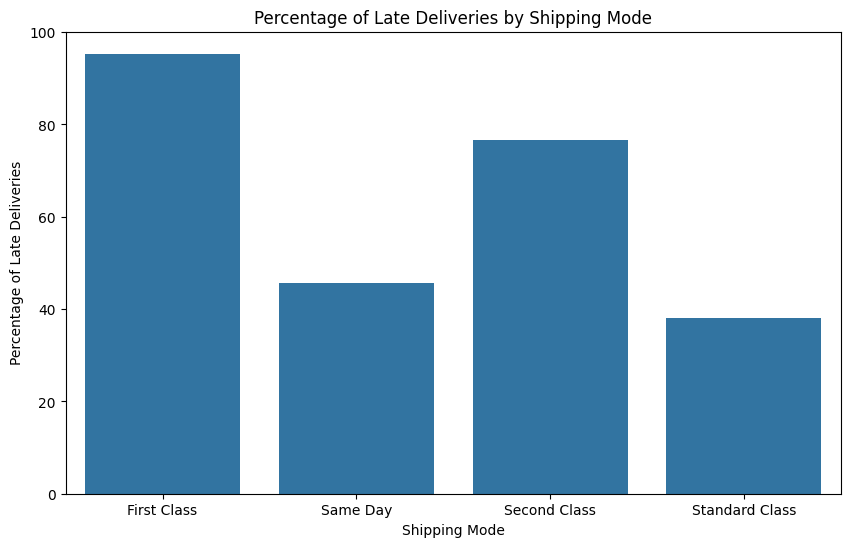

In [8]:
vertices = supply_chain_df.selectExpr("`Shipping Mode` as id").distinct()
edges = supply_chain_df.selectExpr("`Shipping Mode` as src", "`Delivery Status` as dst", "Late_delivery_risk")
g = GraphFrame(vertices, edges)
late_delivery_percentage = F.sum("Late_delivery_risk").alias("late_count") / F.count("Late_delivery_risk") * 100
late_deliveries_by_mode = g.edges.groupBy("src").agg(late_delivery_percentage.alias("PercentageLateDeliveries"))
late_deliveries_df = late_deliveries_by_mode.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="src", y="PercentageLateDeliveries", data=late_deliveries_df)
plt.title("Percentage of Late Deliveries by Shipping Mode")
plt.xlabel("Shipping Mode")
plt.ylabel("Percentage of Late Deliveries")
plt.show()

**Source Destination Relationship Graph**

The below visualization shows the source city and destination city of the product with the delivery status as the relation.

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import GraphFrame

df = spark.read.option("header", "true").csv("DataCoSupplyChainDataset.csv")
sporting_goods_df = df.filter(df["Category Name"] == "Sporting Goods")
sporting_goods_df = sporting_goods_df.limit(10)
nodes_customer = sporting_goods_df.selectExpr("`Customer City` as id").distinct()
nodes_order = sporting_goods_df.selectExpr("`Order City` as id").distinct()
nodes = nodes_customer.union(nodes_order)
edges = sporting_goods_df.selectExpr("`Customer City` as src", "`Order City` as dst", "`Delivery Status` as relationship")
graph = GraphFrame(nodes, edges)
graph.vertices.show()
graph.edges.show()


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+-----------+
|         id|
+-----------+
|     Caguas|
|   San Jose|
|Los Angeles|
|  Tonawanda|
|      Miami|
|  San Ramon|
|     Bekasi|
|    Bikaner|
| Townsville|
|  Toowoomba|
|  Guangzhou|
+-----------+

+-----------+----------+-----------------+
|        src|       dst|     relationship|
+-----------+----------+-----------------+
|     Caguas|    Bekasi| Advance shipping|
|     Caguas|   Bikaner|    Late delivery|
|   San Jose|   Bikaner| Shipping on time|
|Los Angeles|Townsville| Advance shipping|
|     Caguas|Townsville| Advance shipping|
|  Tonawanda| Toowoomba|Shipping canceled|
|     Caguas| Guangzhou|    Late delivery|
|      Miami| Guangzhou|    Late delivery|
|     Caguas| Guangzhou|    Late delivery|
|  San Ramon| Guangzhou|    Late delivery|
+-----------+----------+-----------------+



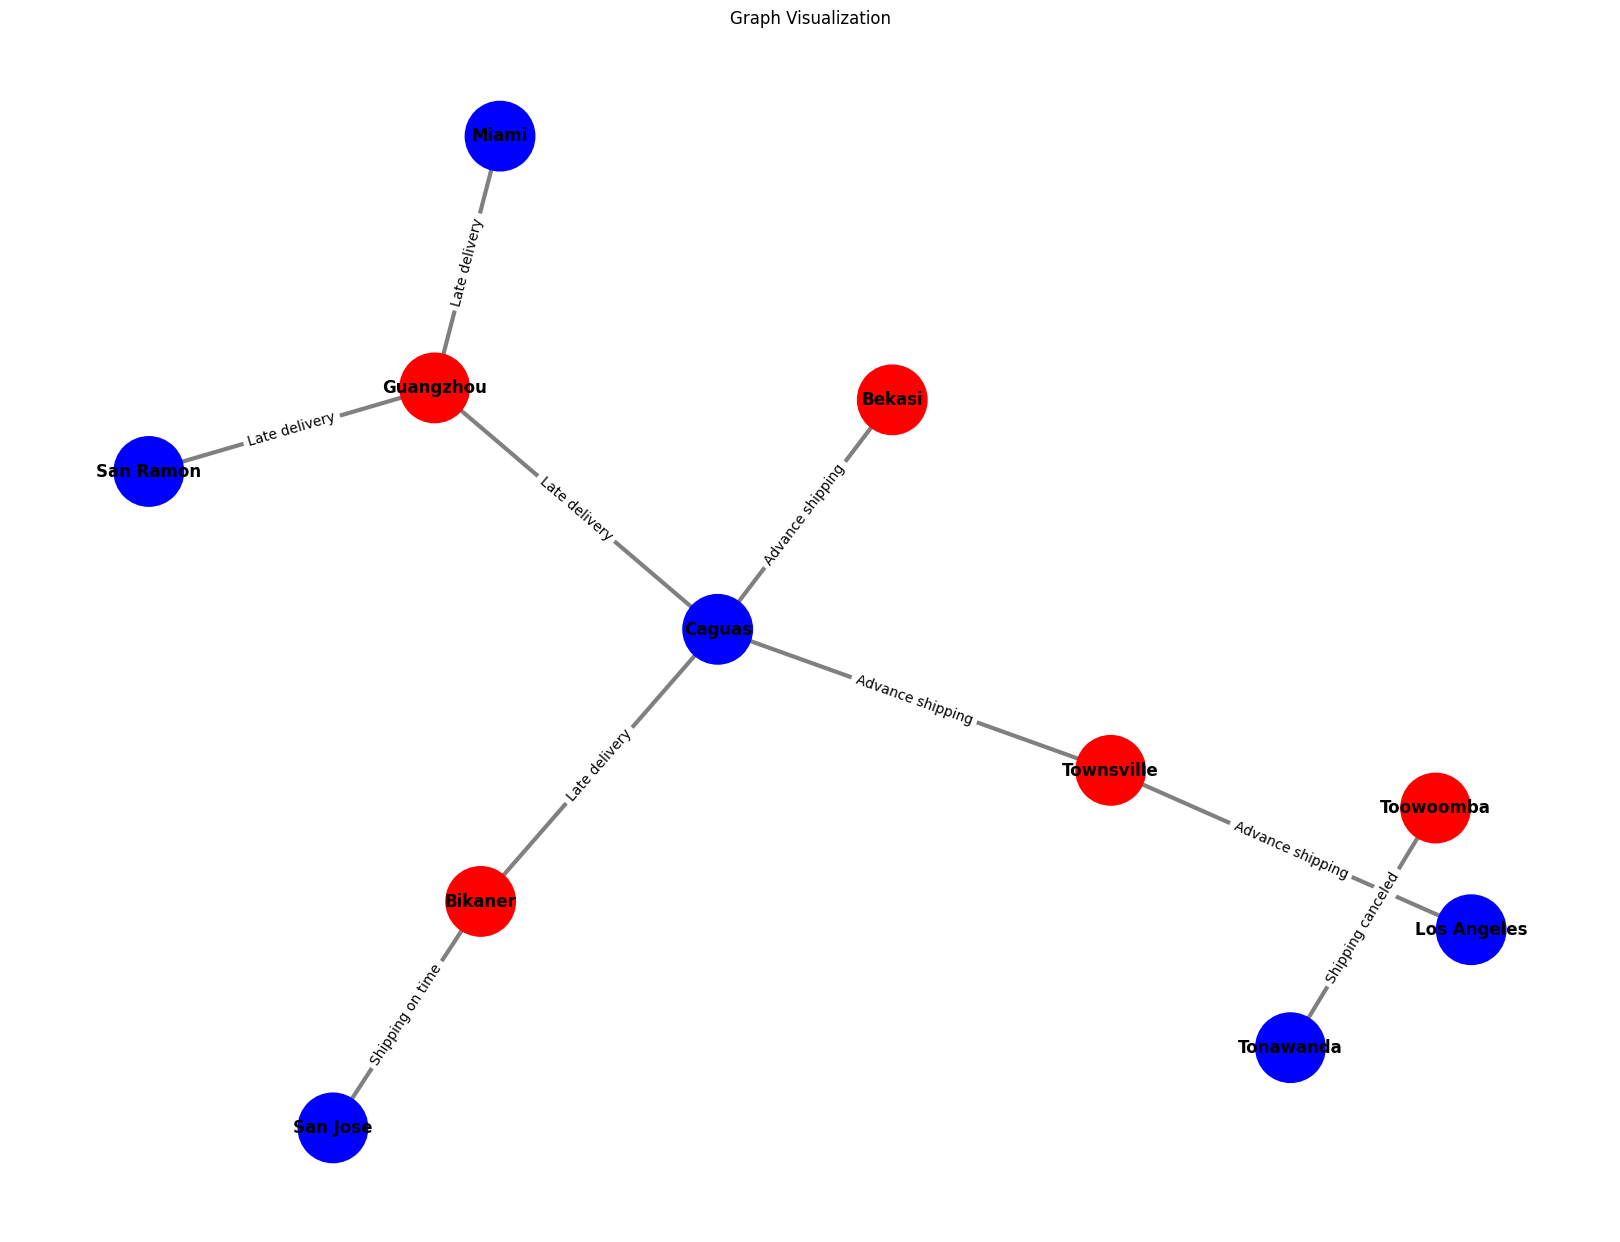

In [10]:
nodes_pdf = nodes.toPandas()
node_colors = {}
for index, row in nodes_pdf.iterrows():
    if row['id'] in nodes_customer.select("id").rdd.flatMap(lambda x: x).collect():
        node_colors[row['id']] = 'blue'  # Color for customer nodes
    else:
        node_colors[row['id']] = 'red'   # Color for order nodes
vertices_pdf = graph.vertices.toPandas()
edges_pdf = graph.edges.toPandas()
nx_graph = nx.Graph()
for index, vertex_row in vertices_pdf.iterrows():
    nx_graph.add_node(vertex_row['id'], color=node_colors[vertex_row['id']])
for index, edge_row in edges_pdf.iterrows():
    nx_graph.add_edge(edge_row['src'], edge_row['dst'], relationship=edge_row['relationship'])

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(nx_graph, k=0.8)
nx.draw(nx_graph, pos, with_labels=True, node_size=2500, node_color=[node_colors[node] for node in nx_graph.nodes()], font_size=12, font_weight='bold', edge_color='gray', width=3, arrows=False)
edge_labels = nx.get_edge_attributes(nx_graph, 'relationship')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels)
plt.title("Graph Visualization")
plt.show()



## Demand Forecasting
Demand forecasting enables businesses to foresee future demand patterns for their products or services based on a range of factors, such as historical data on sales, market trends, and customer behavior. It is not about mere guesswork; instead, it relies on data-driven analysis to make well-informed projections.

Meeting customer expectations: A well-executed demand forecast facilitates the maintenance of a competitive edge and promotes business growth.

Studying the impact of potential environmental changes: If a company plans to introduce a new product similar to an existing one, the forecasting model can be used to study the effect of price changes and help determine the starting price. However, it's important to note that the validity of such a model relies heavily on the similarity between the new and existing products.

Market trend prediction: Seasonal fluctuations and economic indicators are typically incorporated into these models. Even though the economic indicators can significantly increase the complexity of the machine learning model, including them can enhance the accuracy of the forecast, making it a valuable tool for strategic planning.

In [11]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("DemandForecasting") \
    .getOrCreate()

# Load data into a DataFrame
df = spark.read.csv("DataCoSupplyChainDataset.csv", header=True, inferSchema=True)
df.show(5)


+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

## Objective
- Search,filter and aggregate the data which could potentially be useful for predicting product demand

- Perform EDA, understanding the relationship between customers, shipments and orders

- Use a Regression model to predict product demand based on historical data to support strategic decision-making with reliable insights into future market demand.



In [12]:
# Total number of rows and columns
num_rows = df.count()
num_cols = len(df.columns)

# Summary statistics
summary = df.summary().toPandas()

# Top few rows
top_rows = df.show(5, truncate=False)

# Display the results
print("Total Rows:", num_rows)
print("Total Columns:", num_cols)
print("\nSummary Statistics:")
print(summary)
print("\nTop 5 Rows:")
top_rows

# Stop the Spark session
spark.stop()

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+------------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------------------------------+------------+-------------+--------------+--------------------------+--------------+
|Type    |Days for shipping (real)|Days for shipment (scheduled)|B

### Data Aggregation

- Utilize SQL queries to group products by categories such as electronics, apparel, or furniture.
- Analyze demand trends within each category to identify top-performing and low-performing segments.



In [20]:
from pyspark.sql.functions import avg,sum
from pyspark.sql.functions import col

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [14]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("ComplexQueries") \
    .getOrCreate()

# Load data into a DataFrame
df = spark.read.csv("DataCoSupplyChainDataset.csv", header=True, inferSchema=True)

# Create a temporary view
df.createOrReplaceTempView("orders")

In [15]:
# Rank most common markets of orders
common_markets_query = spark.sql("""
    SELECT Market, COUNT(*) AS OrderCount
    FROM orders
    GROUP BY Market
    ORDER BY OrderCount DESC
""")
common_markets_query.show()

+------------+----------+
|      Market|OrderCount|
+------------+----------+
|       LATAM|     51594|
|      Europe|     50252|
|Pacific Asia|     41260|
|        USCA|     25799|
|      Africa|     11614|
+------------+----------+



In [17]:
#Search for repeat customers
repeat_customers_query = spark.sql("""
    SELECT `Customer Id`, `Customer Fname`, `Customer Lname`, COUNT(`Order Id`) AS TotalOrders
    FROM orders
    GROUP BY `Customer Id`, `Customer Fname`, `Customer Lname`
    HAVING TotalOrders > 1
    ORDER BY TotalOrders DESC
""")
repeat_customers_query.show()

+-----------+--------------+--------------+-----------+
|Customer Id|Customer Fname|Customer Lname|TotalOrders|
+-----------+--------------+--------------+-----------+
|       5654|         Jerry|         Smith|         47|
|       5004|       Dorothy|      Friedman|         45|
|      10591|       Deborah|      Humphrey|         45|
|       3708|          Judy|        Miller|         44|
|       5715|         Kelly|         Smith|         44|
|       9371|          Mary|     Patterson|         44|
|      12284|          Mary|         Smith|         43|
|        791|          Mary|         Smith|         43|
|       2641|         Betty|        Spears|         43|
|       1443|        Denise|         Cohen|         43|
|       1464|         Amber|         Dixon|         42|
|      10235|        Joseph|         Singh|         42|
|       2970|       Kenneth|         Smith|         42|
|       1288|        Evelyn|      Thompson|         42|
|       3710|        Ashley|         Smith|     

In [18]:
# Group by delivery status
result = df.groupBy("Delivery Status") \
    .agg(avg("Sales").alias("AvgSales")) \
    .orderBy("AvgSales", ascending=False)

# Show the result
result.show()

# Stop the Spark session
spark.stop()

+-----------------+------------------+
|  Delivery Status|          AvgSales|
+-----------------+------------------+
| Advance shipping|204.79918953786571|
| Shipping on time|204.06343946392687|
|    Late delivery|203.34416344444904|
|Shipping canceled| 202.5155222983644|
+-----------------+------------------+



Exploratory Data Analysis:
- Account for outliers and missing data

- Identify Product Categories with most orders

- Understand current Item Order vs Sales trend

- Explore the regions with most orders to understand potential shipping routes

In [22]:
from pyspark.sql.functions import col, sum as spark_sum

In [23]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("HandleMissingData") \
    .getOrCreate()

# Load data into a DataFrame
df = spark.read.csv("DataCoSupplyChainDataset.csv", header=True, inferSchema=True)

# Replace missing values in categorical columns with "Not available" and numerical columns with 0
df_filled = df.fillna("Not available", subset=[c for c in df.columns if df.select(c).dtypes[0][1] == 'string']) \
              .fillna(0, subset=[c for c in df.columns if df.select(c).dtypes[0][1] != 'string'])

# Check the count of null values after filling
null_counts_filled = df_filled.select([col(c).isNull().cast("int").alias(c) for c in df_filled.columns]) \
                              .agg(*[spark_sum(col(c)).alias(c) for c in df_filled.columns])

# Show the result
null_counts_filled.show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

In [24]:
df_current = df_filled.toPandas()
print(type(df_current))

# To display the first few rows of the Pandas DataFrame
df_current


<class 'pandas.core.frame.DataFrame'>


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,0,1360,73,Not available,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,0,1360,73,Not available,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,0,1360,73,Not available,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,0,1360,73,Not available,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,0,1360,73,Not available,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,0,1004,45,Not available,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,0,1004,45,Not available,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,0,1004,45,Not available,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,0,1004,45,Not available,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/18/2016 20:18,Standard Class


In [25]:
# List of columns to drop for ensemble training
columns_to_drop = ['Product Image', 'Product Status', 'Order Zipcode', 'Customer Street']

# Drop the columns from df_current
df_current_cleaned = df_current.drop(columns=columns_to_drop)

# Now df_current_cleaned does not contain the dropped columns
df_current_cleaned

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Description,Product Name,Product Price,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,Southeast Asia,Java Occidental,COMPLETE,1360,73,Not available,Smart watch,327.750000,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,South Asia,Rajast�n,PENDING,1360,73,Not available,Smart watch,327.750000,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,South Asia,Rajast�n,CLOSED,1360,73,Not available,Smart watch,327.750000,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,Oceania,Queensland,COMPLETE,1360,73,Not available,Smart watch,327.750000,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,Oceania,Queensland,PENDING_PAYMENT,1360,73,Not available,Smart watch,327.750000,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,Eastern Asia,Shangh�i,CLOSED,1004,45,Not available,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,Eastern Asia,Osaka,COMPLETE,1004,45,Not available,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,Oceania,Australia del Sur,PENDING,1004,45,Not available,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,Oceania,Australia del Sur,PENDING_PAYMENT,1004,45,Not available,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,1/18/2016 20:18,Standard Class


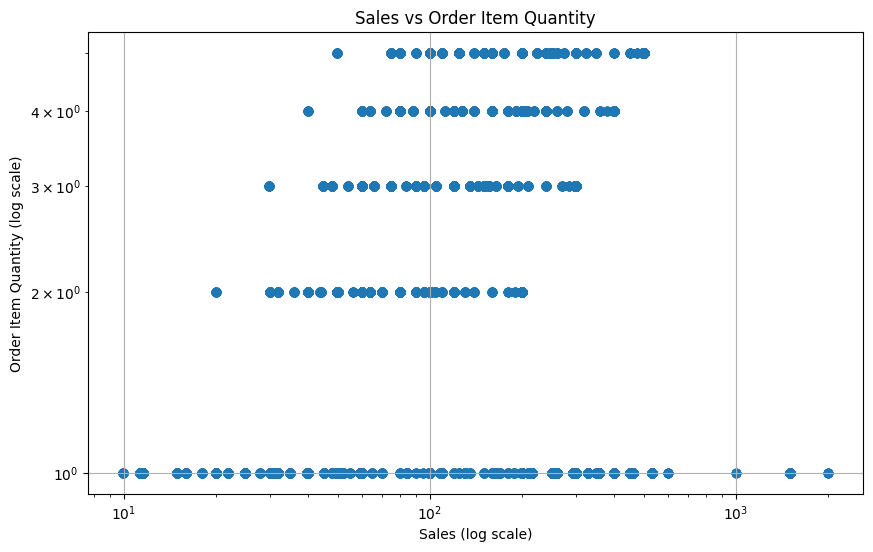

In [26]:
import matplotlib.pyplot as plt

# Plotting Sales vs Order Item Quantity with log scaling
plt.figure(figsize=(10, 6))
plt.scatter(df_current_cleaned['Sales'], df_current_cleaned['Order Item Quantity'], alpha=0.5)
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis
plt.title('Sales vs Order Item Quantity')
plt.xlabel('Sales (log scale)')
plt.ylabel('Order Item Quantity (log scale)')
plt.grid(True)
plt.show()


<ipython-input-27-e4938c03d105>:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


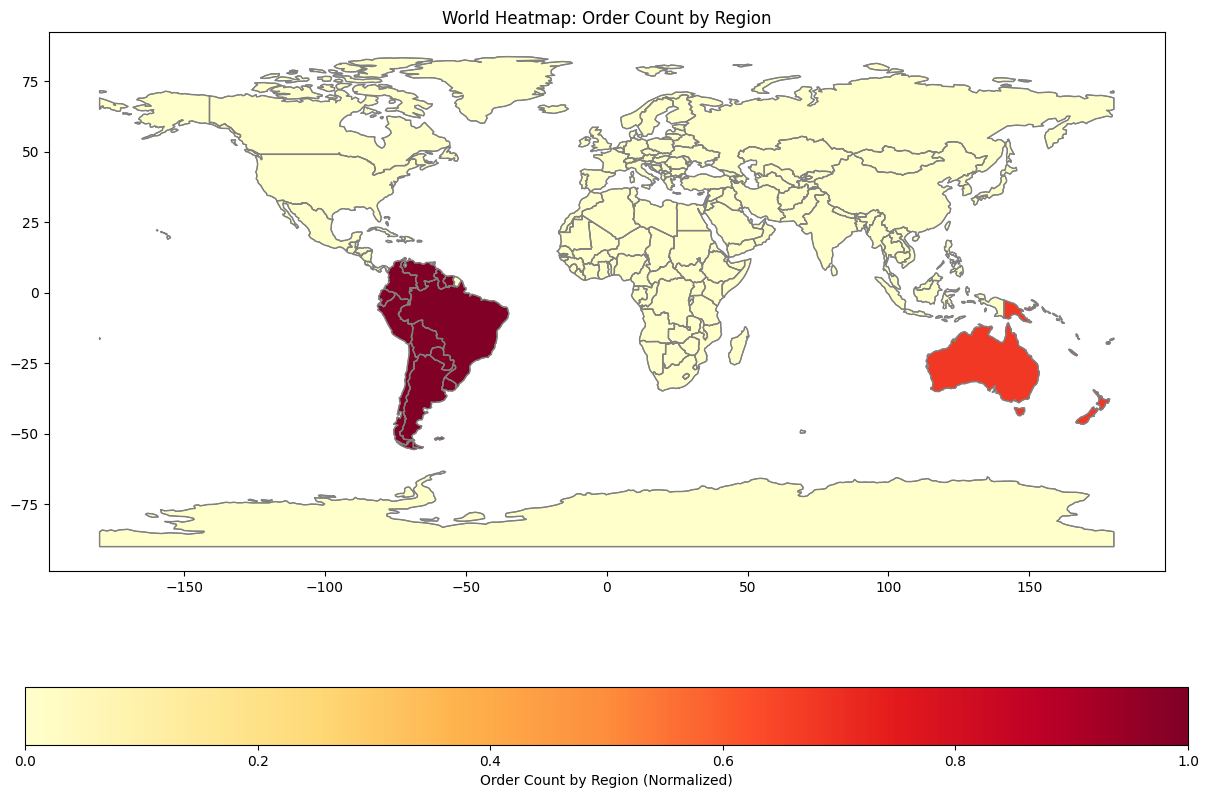

In [27]:
#world heatmap - customer region vs sales
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have a DataFrame df_current_cleaned with 'Order Region' column
# Create a sample dataframe with 'Order Region' and count of orders
orders_by_region = df_current_cleaned['Order Region'].value_counts().reset_index()
orders_by_region.columns = ['Order Region', 'Order Count']

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with orders data
world_orders = world.merge(orders_by_region, how='left', left_on='continent', right_on='Order Region')

# Fill NaN values with 0 (for regions with no order data)
world_orders['Order Count'] = world_orders['Order Count'].fillna(0)

# Normalize order count for better color scaling
max_order_count = world_orders['Order Count'].max()
world_orders['Order Count Normalized'] = world_orders['Order Count'] / max_order_count

# Plotting the world heatmap with adjusted scaling
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_orders.boundary.plot(ax=ax, linewidth=0.8, color='gray')
world_orders.plot(column='Order Count Normalized', ax=ax, legend=True,
                  legend_kwds={'label': "Order Count by Region (Normalized)",
                               'orientation': "horizontal"},
                  cmap='YlOrRd', edgecolor='gray')
ax.set_title('World Heatmap: Order Count by Region')
plt.show()


In [28]:
# Remove duplicate rows
df_current_cleaned = df_current_cleaned.drop_duplicates()
df_current_cleaned

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Description,Product Name,Product Price,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,Southeast Asia,Java Occidental,COMPLETE,1360,73,Not available,Smart watch,327.750000,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,South Asia,Rajast�n,PENDING,1360,73,Not available,Smart watch,327.750000,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,South Asia,Rajast�n,CLOSED,1360,73,Not available,Smart watch,327.750000,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,Oceania,Queensland,COMPLETE,1360,73,Not available,Smart watch,327.750000,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,Oceania,Queensland,PENDING_PAYMENT,1360,73,Not available,Smart watch,327.750000,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,Eastern Asia,Shangh�i,CLOSED,1004,45,Not available,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,Eastern Asia,Osaka,COMPLETE,1004,45,Not available,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,Oceania,Australia del Sur,PENDING,1004,45,Not available,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,Oceania,Australia del Sur,PENDING_PAYMENT,1004,45,Not available,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,1/18/2016 20:18,Standard Class


In [29]:
# Specify the columns to keep
selected_columns = [
    'order date (DateOrders)',
    'Order Item Quantity',
    'Sales',
    'Category Name',
    'Customer Segment',
    'Order Region',
    'Shipping Mode',
    'Market',
    'Department Name',
    'Type',
    'Customer State',
    'Order Status',
    'Order Item Profit Ratio',
    'Order Profit Per Order'
]

# Create the subset dataframe
df_subset = df_current_cleaned[selected_columns]

# Display the first few rows of the subset dataframe
df_subset.head()


,order date (DateOrders),Order Item Quantity,Sales,Category Name,Customer Segment,Order Region,Shipping Mode,Market,Department Name,Type,Customer State,Order Status,Order Item Profit Ratio,Order Profit Per Order
0,1/31/2018 22:56,1,327.75,Sporting Goods,Consumer,Southeast Asia,Standard Class,Pacific Asia,Fitness,DEBIT,PR,COMPLETE,0.29,91.250000
1,1/13/2018 12:27,1,327.75,Sporting Goods,Consumer,South Asia,Standard Class,Pacific Asia,Fitness,TRANSFER,PR,PENDING,-0.80,-249.089996
2,1/13/2018 12:06,1,327.75,Sporting Goods,Consumer,South Asia,Standard Class,Pacific Asia,Fitness,CASH,CA,CLOSED,-0.80,-247.779999
3,1/13/2018 11:45,1,327.75,Sporting Goods,Home Office,Oceania,Standard Class,Pacific Asia,Fitness,DEBIT,CA,COMPLETE,0.08,22.860001
4,1/13/2018 11:24,1,327.75,Sporting Goods,Corporate,Oceania,Standard Class,Pacific Asia,Fitness,PAYMENT,PR,PENDING_PAYMENT,0.45,134.210007


In [30]:
df_encoded = df_subset.copy()

# Columns to encode using one-hot encoding
columns_to_encode = [
    'Category Name',
    'Customer Segment',
    'Order Region',
    'Shipping Mode',
    'Market',
    'Department Name',
    'Type',
    'Customer State',
]

# Apply one-hot encoding to the specified columns
df_encoded = pd.get_dummies(df_encoded, columns=columns_to_encode)

# Display the first few rows of the encoded dataframe
df_encoded.head()

,order date (DateOrders),Order Item Quantity,Sales,Order Status,Order Item Profit Ratio,Order Profit Per Order,Category Name_Accessories,Category Name_As Seen on TV!,Category Name_Baby,Category Name_Baseball & Softball,...,Customer State_PR,Customer State_RI,Customer State_SC,Customer State_TN,Customer State_TX,Customer State_UT,Customer State_VA,Customer State_WA,Customer State_WI,Customer State_WV
0,1/31/2018 22:56,1,327.75,COMPLETE,0.29,91.250000,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1/13/2018 12:27,1,327.75,PENDING,-0.80,-249.089996,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1/13/2018 12:06,1,327.75,CLOSED,-0.80,-247.779999,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1/13/2018 11:45,1,327.75,COMPLETE,0.08,22.860001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1/13/2018 11:24,1,327.75,PENDING_PAYMENT,0.45,134.210007,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [31]:
df_encoded.to_csv('DataCoSupplyChain_Processed.csv',index = False)

## Model Training

- Target variable: Order Item Quantity (i.e: Product demand)
- Using a Random Forest Ensemble model (via pySpark) for model training
- Our pipeline assembles our processed data into feature vectors and initiates model training
- Additional modifications include hyperaparameter tuning, tree parameters and cross-validation

- Objective is to predict the order item quantity for future dates based on historical data and see how it aligns with actual data



In [33]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create a Spark session
spark = SparkSession.builder \
    .appName("DemandForecasting") \
    .getOrCreate()

# Read the processed data into a Spark DataFrame
data = spark.read.csv("DataCoSupplyChain_Processed.csv", header=True, inferSchema=True)

# Drop the original "Order date (DateOrders)" column
data = data.drop("Order date (DateOrders)", "Order Status")

# Assemble features
feature_columns = data.columns
target_variable = 'Order Item Quantity'  # Target variable for demand forecasting
feature_columns = [col for col in feature_columns if col != target_variable]  # Remove the target variable
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Define the ensemble algorithm (Random Forest Regressor)
rf = RandomForestRegressor(featuresCol='features', labelCol=target_variable, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and testing sets
training, test = data.randomSplit([0.8, 0.2], seed=42)

# Define parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol=target_variable, metricName='rmse')

# Define CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          seed=42)

# Fit the model
cv_model = crossval.fit(training)

# Make predictions on the testing data
predictions = cv_model.transform(test)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

# Best model from CrossValidator
best_model = cv_model.bestModel

# Best model's parameters
print("Best Model Parameters:")
print("Num Trees:", best_model.stages[1]._java_obj.getNumTrees())
print("Max Depth:", best_model.stages[1]._java_obj.getMaxDepth())

# Select relevant columns from predictions DataFrame
selected_predictions = predictions.select("Order Item Quantity", "prediction")

# Show the predictions
selected_predictions.show()

# Optionally, you can save the predictions to a CSV file
selected_predictions.write.csv("predictions.csv", header=True)

# Stop the Spark session
spark.stop()


Root Mean Squared Error (RMSE): 0.20456379588665569
Best Model Parameters:
Num Trees: 30
Max Depth: 15
+-------------------+------------------+
|Order Item Quantity|        prediction|
+-------------------+------------------+
|                  1| 2.232828189373943|
|                  1| 1.906662109220879|
|                  1|1.9972810445323372|
|                  1|1.6579887997418423|
|                  1|1.7818449279428974|
|                  1| 2.109098727202778|
|                  1| 1.573413244352109|
|                  1|1.7021586301407132|
|                  1|1.7381146843180573|
|                  1|1.5962705897720189|
|                  1|1.8395801511642085|
|                  1|1.6693624263690832|
|                  1| 1.665411993829036|
|                  1|2.0717463914560863|
|                  1|1.0161308386267043|
|                  1| 1.014435629724192|
|                  1|1.0161308386267043|
|                  1|1.0029193551658866|
|                  1|1.0011414534422

The Random Forest Regressor likely worked well in this demand forecasting scenario for several reasons:

Robust to Outliers: Random forests are less sensitive to outliers than traditional regression models, making them suitable for datasets with varying demand fluctuations.

Product demand relations are highly non-linear which in turn can be evaluated using random forest modelling (multiple decision trees)

On average our model predicts that the order quantity for most of the items will increase in the coming year with a relatively low RMSE of 0.204. This is in alignment with the previous EDA conducted showing an upward trend in Sales vs Order Item Quantity

In order to develop a robust supply chain strategy to account for the upcoming demand companies can look into understanding their shipping routes better and modify them if needed.

# Shipment Classification

In [34]:
session=SparkSession.builder.appName("finalproject").master("local").getOrCreate()
supply_chain_df=session.read.csv("DataCoSupplyChainDataset.csv", header=True, inferSchema=True)

We are using classificaltion models to predict the delivery status of a given order. By this analysis we can frame our shipping mode such that our shipment is not delivered late. In order to predict Delivery Status we are using following parameters.
1. Market - Market to where the order is delivered : Africa, Europe, LATAM, Pacific Asia, USCA.
2. Order City -  Destination city of the order
3. Order Country - Destination country of the order
4. Category Name - Product category
5. Shipping Mode - Mode by which the shipping is done: Standard Class, First Class, Second Class, Same Day
6. Latitude - Latitude corresponding to location of store
7. Longitude - Longitude corresponding to location of store
8. Order Item Quantity - Number of products per order

We are training three classification models to predict the Delivery Status for given conditions. The idea behind this modelling is to facilitate the decision making at supplier's end to choose the perfect shipping mode and shop to supply the product on time. If somehow for a given source, destination and shipping mode the delivery status comes out to be late then may be we can change source or shipping mode to make sure the shipment is delivered on time.   

In [35]:
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["Market","Order City","Order Country","Category Name","Delivery Status","Shipping Mode"],outputCols=["NewMarket","New_Order_City","New_Order_Country","New_Category_Name","New_Delivery_Status","New_Shipping_Mode"], stringOrderType="alphabetAsc")
str_obj.setHandleInvalid("keep")

StringIndexer_bc560e5f3c16

In [36]:
#Using one hot encoding for categorical variables
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["NewMarket","New_Order_City","New_Order_Country","New_Category_Name","New_Delivery_Status","New_Shipping_Mode"],outputCols=["FinalMarket","Final_Order_City","Final_Order_Country","Final_Category_Name","Final_Delivery_Status","Final_Shipping_Mode"])

In [37]:
from  pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["FinalMarket","Final_Order_City","Final_Order_Country","Final_Category_Name","Final_Shipping_Mode","Latitude","Longitude","Order Item Quantity","Late_delivery_risk"], outputCol="all_features")

In [38]:
#Creating a logistic regression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='all_features', labelCol="New_Delivery_Status")
from pyspark.ml import Pipeline
lrpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,lr])
training, test=supply_chain_df.randomSplit([0.8,0.2],seed=123)
lrmodel=lrpipeline.fit(training)
lrresults=lrmodel.transform(test)
lrresults.show(2, truncate=False)

+----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+----------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+-------------------------+----------------+-------------+---------------+-----------+------------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+----------+----------------+----------------------+---------------+----------------+------------+-------------+---------------+-------------------+-------------------+--------------------------------------------------------------------------------------+---------------------------------------------+-------------+--------------+--------------------------+-----------

In [39]:
#Determining the accuracy
lrresults=lrresults.withColumn("compare",lrresults['New_Delivery_Status']-lrresults['prediction'])
correct=lrresults.filter(lrresults['compare']==0.0).count()
incorrect=lrresults.filter(lrresults['compare']!=0.0).count()
lraccuracy = correct/(correct+incorrect)
print(f'The accuracy of logistic regression model is {lraccuracy}')

The accuracy of logistic regression model is 0.8596370065471421


In [40]:
from pyspark.ml.classification import DecisionTreeClassifier
tree=DecisionTreeClassifier(featuresCol='all_features', labelCol="New_Delivery_Status")
treepipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,tree])
treemodel=treepipeline.fit(training)
treeresults=treemodel.transform(test)
treeresults.show(2, truncate=False)

+----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+----------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+-------------------------+----------------+-------------+---------------+-----------+------------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+----------+----------------+----------------------+---------------+----------------+------------+-------------+---------------+-------------------+-------------------+--------------------------------------------------------------------------------------+---------------------------------------------+-------------+--------------+--------------------------+-----------

In [41]:
# Determining Decision Tree Accuracy
treeresults=treeresults.withColumn("compare",treeresults['New_Delivery_Status']-treeresults['prediction'])
correct=treeresults.filter(treeresults['compare']==0).count()
incorrect=treeresults.filter(treeresults['compare']!=0).count()
treeaccuracy = correct/(correct+incorrect)
print(f'The accuracy of decision tree is {treeaccuracy}')

The accuracy of decision tree is 0.8531727395784414


In [42]:
# Creating a random forest classifier model
from pyspark.ml.classification import RandomForestClassifier
forest=RandomForestClassifier(featuresCol='all_features', labelCol="New_Delivery_Status")
forestpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,forest])
forestmodel=forestpipeline.fit(training)
forestresults=forestmodel.transform(test)
forestresults.show(2, truncate=False)

+----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+----------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+-------------------------+----------------+-------------+---------------+-----------+------------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+----------+----------------+----------------------+---------------+----------------+------------+-------------+---------------+-------------------+-------------------+--------------------------------------------------------------------------------------+---------------------------------------------+-------------+--------------+--------------------------+-----------

In [43]:
# Determining Random Forest Classifier Accuracy
forestresults=forestresults.withColumn("compare",forestresults['New_Delivery_Status']-forestresults['prediction'])
correct=forestresults.filter(forestresults['compare']==0).count()
incorrect=forestresults.filter(forestresults['compare']!=0).count()
forestaccuracy = correct/(correct+incorrect)
print(f'The accuracy of random forest model is {forestaccuracy}.')

The accuracy of random forest model is 0.5501256940799469.


It can be made the the best model for this problem would be logistic regression because that is giving the maximum accuracy amongst the three models.

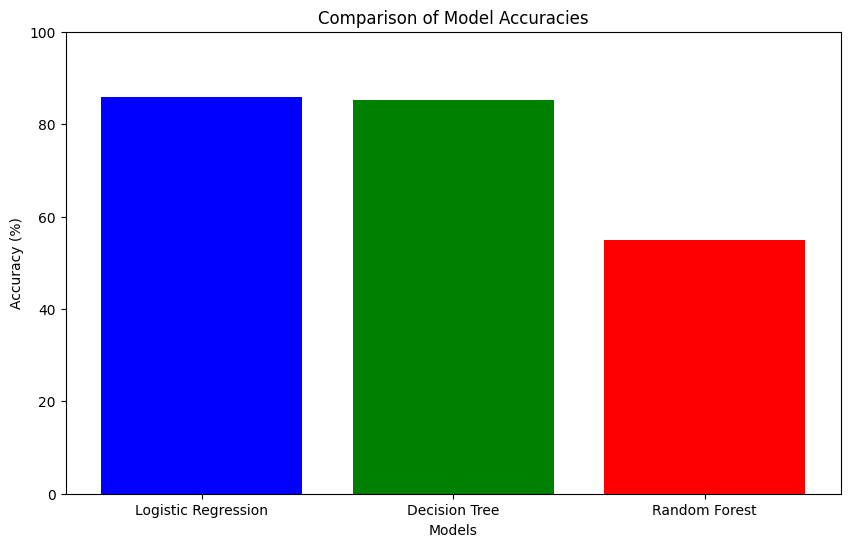

In [44]:
import matplotlib.pyplot as plt
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']

accuracies = [lraccuracy*100, treeaccuracy*100, forestaccuracy*100]

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 100)

# Display the plot
plt.show()
